<a href="https://colab.research.google.com/github/MithunW/MachineLearningProject/blob/main/Pump_it_Up_Data_Mining_the_Water_Table_Initial_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


## **Importing General Libraries and Test Train Data**

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train_features = pd.read_csv('/content/gdrive/My Drive/Pump it Up: Data Mining the Water Table/Training set values.csv')
train_labels = pd.read_csv('/content/gdrive/My Drive/Pump it Up: Data Mining the Water Table/Training set labels.csv')
test_features = pd.read_csv('/content/gdrive/My Drive/Pump it Up: Data Mining the Water Table/Test set values.csv')

## **Know the Data**

In [3]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
X_train=train_features.copy()
y_train=train_labels.copy()
X_train.drop("id",axis=1,inplace=True)
y_train.drop("id",axis=1,inplace=True)

In [6]:
X_train.describe(include='all')

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,59400,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400,55523,31234,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1,12,2696,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400,36793,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN,NaN,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN,NaN,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Find Missing Values in DataFrame**

In [7]:
print('\nNull Values in Training \n{}'.format(X_train.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_features.isnull().sum()))



Null Values in Training 
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group

In [8]:
#Create list of features in the data set
column_names=list(train_features)
feature_columns=column_names.copy()
feature_columns.remove("id")

In [9]:
#Unique data count of each column in train dataset
X_train.nunique()

amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

## **Solutions for Missing Values in Train and Test Data**

In [10]:
#Drop scheme_name and subvillage since it has lots of missing values and high cardinality
feature_columns.remove("scheme_name")
feature_columns.remove("subvillage")
feature_columns.remove("recorded_by")
feature_columns.remove("date_recorded")
X_train.drop("scheme_name", axis=1, inplace=True)
test_features.drop("scheme_name", axis=1, inplace=True)
X_train.drop("subvillage", axis=1, inplace=True)
test_features.drop("subvillage", axis=1, inplace=True)
X_train.drop("recorded_by", axis=1, inplace=True)
test_features.drop("recorded_by", axis=1, inplace=True)
X_train.drop("date_recorded", axis=1, inplace=True)
test_features.drop("date_recorded", axis=1, inplace=True)

#Fill missing values in funder column with most frequent value of the column
X_train["funder"] = X_train["funder"].fillna("Government Of Tanzania")
test_features["funder"] = test_features["funder"].fillna("Government Of Tanzania")

#Fill missing values in installer column with most frequent value of the column
X_train["installer"] = X_train["installer"].fillna("DWE")
test_features["installer"] = test_features["installer"].fillna("DWE")

#Fill missing values in public_meeting column with most frequent value of the column
X_train["public_meeting"] = X_train["public_meeting"].fillna(True)
test_features["public_meeting"] = test_features["public_meeting"].fillna(True)

#Fill missing values in schema_management column with most frequent value of the column
X_train["scheme_management"] = X_train["scheme_management"].fillna("VWC")
test_features["scheme_management"] = test_features["scheme_management"].fillna("VWC")

#Fill missing values in permit column with most frequent value of the column
X_train["permit"] = X_train["permit"].fillna(True)
test_features["permit"] = test_features["permit"].fillna(True)

# most_frequent_treated_cols=["funder", "installer", "public_meeting", "scheme_management", "permit"]

# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
# imputer.fit_transform(X_train[most_frequent_treated_cols])
# imputer.transform(test_features[most_frequent_treated_cols])

print('\nNull Values in Training \n{}'.format(X_train.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_features.isnull().sum()))


Null Values in Training 
amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

Null Values in 

## **Duplicate Values in Train and Test** **Dataset**

In [11]:
print('\nDuplicated values in train {}'.format(X_train.duplicated(subset=feature_columns).sum()))
print('Duplicated values in test {}'.format(test_features.duplicated(subset=feature_columns).sum()))


Duplicated values in train 118
Duplicated values in test 8


In [12]:
#Remove duplicates from the train/test data
X_train["labels"] = y_train
X_train.drop_duplicates(subset=feature_columns, inplace=True)
# X_train.drop("labels",axis=1,inplace=True)

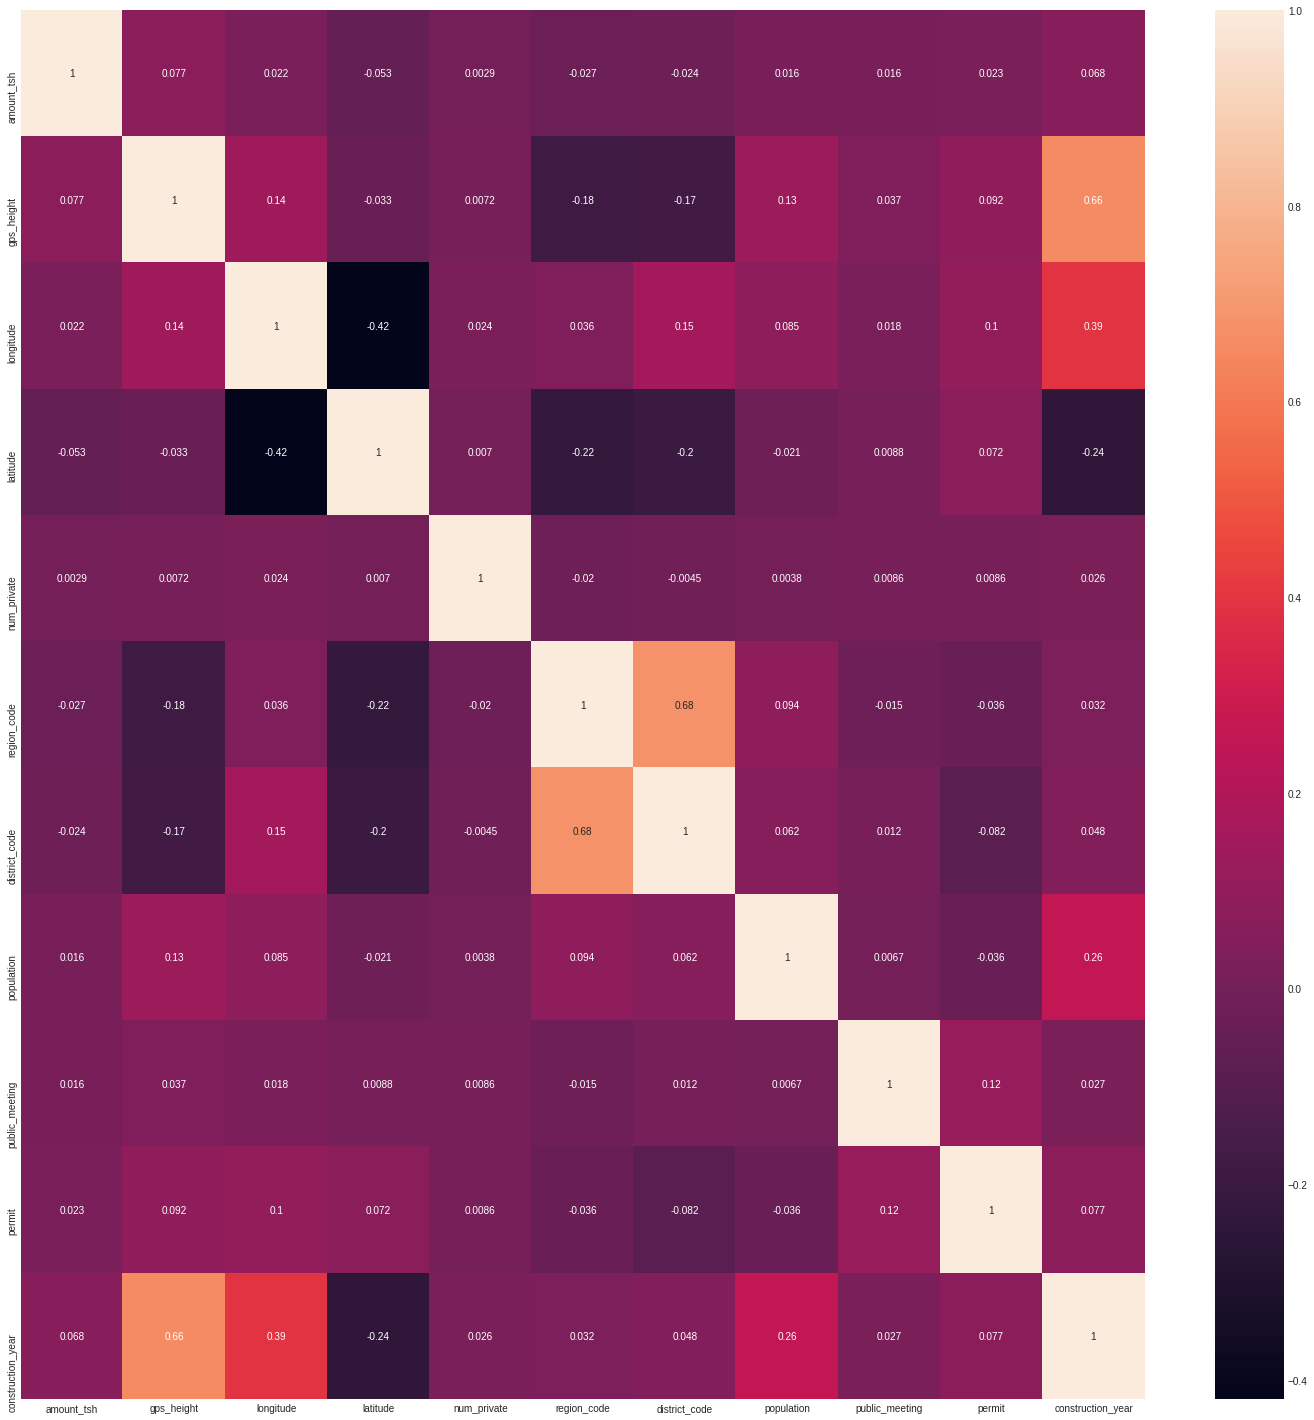

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), annot=True)
plt.tight_layout()

## **Correlation Data**

*   gps_height x construction_year 0.66
*   installer x funder 0.54
*   region_code x district-code 0.68
*   management x scheme_management 0.66
*   extraction_type x extraction_type_group 0.95
*   extraction_type_class x extraction_type 0.7
*   extraction_type_class x extraction_type_group 0.78
*   management_group x management 0.6
*   payment_type x payment 0.69
*   quantity_group x quantity 1
*   source_type x source 0.94
*   waterpoint_type x waterpoint_type_group 0.98

Drop one column from correlations more than 0.9
*   extraction_type_group
*   extraction_type
*   quantity_group
*   source_type
*   waterpoint_type_group


In [14]:
drop_cols=['extraction_type_group','quantity_group', 'extraction_type','source_type','waterpoint_type_group']
for col in drop_cols:
  X_train.drop(col, axis=1, inplace=True)
  test_features.drop(col, axis=1, inplace=True)
  feature_columns.remove(col)

**Feature Engineering to water head and population data**

In [15]:
# X_train["water_population"] = X_train["amount_tsh"]/X_train["population"]
# test_features["water_population"] = test_features["amount_tsh"]/test_features["population"]
# #Fill missing values
# X_train["water_population"] = (X_train["water_population"].fillna(0)).astype({"water_population": 'int32'})
# test_features["water_population"] = (test_features["water_population"].fillna(0)).astype({"water_population": 'int32'})

# drop_cols_water_pop =["amount_tsh","population"]
# for col in drop_cols_water_pop:
#   X_train.drop(col, axis=1, inplace=True)
#   test_features.drop(col, axis=1, inplace=True)
#   feature_columns.remove(col)

In [16]:
X_train

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_class,waterpoint_type,labels
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,False,1999,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,groundwater,communal standpipe,functional
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Mara,20,2,Serengeti,Natta,280,True,Other,True,2010,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,True,2009,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,surface,communal standpipe multiple,functional
3,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,True,1986,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,0,True,VWC,True,0,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,Water Board,True,1999,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,spring,groundwater,communal standpipe,functional
59396,4700.0,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Iringa,11,4,Njombe,Ikondo,56,True,VWC,True,1996,gravity,vwc,user-group,pay annually,annually,soft,good,enough,river,surface,communal standpipe,functional
59397,0.0,Government Of Tanzania,0,DWE,34.017087,-8.750434,Mashine,0,Rufiji,Mbeya,12,7,Mbarali,Chimala,0,True,VWC,False,0,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,machine dbh,groundwater,hand pump,functional
59398,0.0,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,VWC,True,0,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,shallow well,groundwater,hand pump,functional


Feature Engineering to Population based on the region

In [17]:
# region_frame = pd.concat([lat_long_frame_X,lat_long_frame_y])
# X_train["avg_population"] = (X_train.groupby("region")["population"].transform("mean") 

# customer[["State", "Income", "AverageIncome"]].head(10)

**Feature Engineering to Latitude Longitude and other geographical data**

In [18]:
print("Row count in X_train dataframe= "+ str(X_train["latitude"].count()))
print("Row count in test dataframe= "+ str(test_features["latitude"].count()))
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=6)
lat_long_frame_X = X_train[["latitude","longitude"]].copy()
lat_long_frame_y = test_features[["latitude","longitude"]].copy()
lat_long_frame = pd.concat([lat_long_frame_X,lat_long_frame_y])
lat_long_frame["coordinates"] = kmeans.fit_predict(lat_long_frame[["latitude","longitude"]])
lat_long_frame["coordinates"] = lat_long_frame["coordinates"].astype("category")
print("Row count in lat_long_frame dataframe= "+ str(lat_long_frame["latitude"].count()))
X_train["coordinates"] = (lat_long_frame["coordinates"].iloc[:(X_train["latitude"].count())]).astype(int)
test_features["coordinates"] = (lat_long_frame["coordinates"].iloc[(X_train["latitude"].count()):]).astype(int)

Row count in X_train dataframe= 59282
Row count in test dataframe= 14850
Row count in lat_long_frame dataframe= 74132


In [19]:
lat_long_frame["coordinates"]

0        3
1        4
2        4
3        5
4        0
        ..
14845    2
14846    2
14847    4
14848    3
14849    3
Name: coordinates, Length: 74132, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

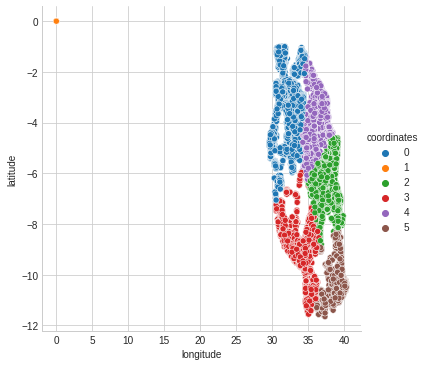

In [20]:
sns.relplot(x="longitude", y="latitude", hue="coordinates", data=lat_long_frame);

In [21]:
drop_cols_geo=['latitude','longitude','region','region_code', 'district_code']
for col in drop_cols_geo:
  X_train.drop(col, axis=1, inplace=True)
  test_features.drop(col, axis=1, inplace=True)
  feature_columns.remove(col)

In [22]:
X_train.nunique()

amount_tsh                  98
funder                    1897
gps_height                2428
installer                 2145
wpt_name                 37400
num_private                 65
basin                        9
lga                        125
ward                      2092
population                1049
public_meeting               2
scheme_management           12
permit                       2
construction_year           55
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_class                 3
waterpoint_type              7
labels                       3
coordinates                  6
dtype: int64

## **Remove High Cardinality Columns from Dataset**

In [23]:
high_cardinality_cols = ['funder','installer','wpt_name','ward','lga']
for col in high_cardinality_cols:
  X_train.drop(col, axis=1, inplace=True)
  test_features.drop(col, axis=1, inplace=True)
  feature_columns.remove(col)


Feature Engineering to "amount_tsh","gps_height","population" data





In [24]:
print("Row count in X_train dataframe= "+ str(X_train["amount_tsh"].count()))
print("Row count in test dataframe= "+ str(test_features["amount_tsh"].count()))

# Create cluster feature
kmeans = KMeans(n_clusters=6)
tsh_gps_pop_X = X_train[["amount_tsh","gps_height","population"]].copy()
tsh_gps_pop_y = test_features[["amount_tsh","gps_height","population"]].copy()
tsh_gps_pop_frame = pd.concat([tsh_gps_pop_X,tsh_gps_pop_y])
tsh_gps_pop_frame["tsh_gps_pop"] = kmeans.fit_predict(tsh_gps_pop_frame[["amount_tsh","gps_height","population"]])
tsh_gps_pop_frame["tsh_gps_pop"] = tsh_gps_pop_frame["tsh_gps_pop"].astype("category")
print("Row count in tsh_gps_pop_frame dataframe= "+ str(tsh_gps_pop_frame["tsh_gps_pop"].count()))
X_train["tsh_gps_pop"] = (tsh_gps_pop_frame["tsh_gps_pop"].iloc[:(X_train["amount_tsh"].count())]).astype(int)
test_features["tsh_gps_pop"] = (tsh_gps_pop_frame["tsh_gps_pop"].iloc[(X_train["amount_tsh"].count()):]).astype(int)

Row count in X_train dataframe= 59282
Row count in test dataframe= 14850
Row count in tsh_gps_pop_frame dataframe= 74132


In [25]:
test_features["tsh_gps_pop"]

0        4
1        4
2        4
3        0
4        4
        ..
14845    0
14846    0
14847    4
14848    4
14849    0
Name: tsh_gps_pop, Length: 14850, dtype: int64

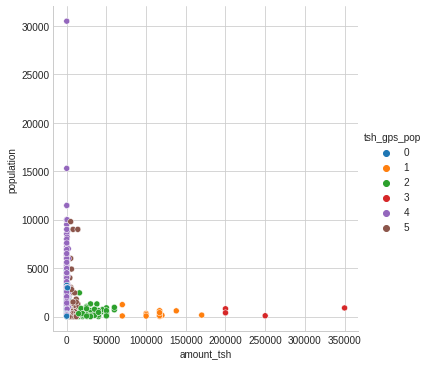

In [26]:
sns.relplot(x="amount_tsh", y="population", hue="tsh_gps_pop", data=tsh_gps_pop_frame);

In [27]:
clustered_cols = ["amount_tsh","gps_height","population"]
for col in clustered_cols:
  X_train.drop(col, axis=1, inplace=True)
  test_features.drop(col, axis=1, inplace=True)
  feature_columns.remove(col)


In [28]:
X_train.head()

,num_private,basin,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_class,waterpoint_type,labels,coordinates,tsh_gps_pop
0,0,Lake Nyasa,True,VWC,False,1999,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,groundwater,communal standpipe,functional,3,5
1,0,Lake Victoria,True,Other,True,2010,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,4,4
2,0,Pangani,True,VWC,True,2009,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,surface,communal standpipe multiple,functional,4,0
3,0,Ruvuma / Southern Coast,True,VWC,True,1986,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional,5,0
4,0,Lake Victoria,True,VWC,True,0,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,0,0


In [29]:
X_train.nunique()

num_private              65
basin                     9
public_meeting            2
scheme_management        12
permit                    2
construction_year        55
extraction_type_class     7
management               12
management_group          5
payment                   7
payment_type              7
water_quality             8
quality_group             6
quantity                  5
source                   10
source_class              3
waterpoint_type           7
labels                    3
coordinates               6
tsh_gps_pop               6
dtype: int64

In [30]:
test_features.nunique()

id                       14850
num_private                 36
basin                        9
public_meeting               2
scheme_management           11
permit                       2
construction_year           55
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_class                 3
waterpoint_type              7
coordinates                  6
tsh_gps_pop                  6
dtype: int64

## **Encode Categorical Columns**

In [31]:
from sklearn.preprocessing import OneHotEncoder

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
object_cols.remove('labels')
# preprocessor = OneHotEncoder(handle_unknown='ignore', sparse=False)
# X_train[object_cols] = X_train[object_cols].apply(preprocessor.fit_transform)
# test_features[object_cols] = test_features[object_cols].apply(preprocessor.transform)
# X_train[['labels']] = X_train[['labels']].apply(preprocessor.fit_transform)
# X_train.head()

from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_features[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = test_features.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = test_features.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

In [32]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='merror')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target],dtrain_predprob,multi_class='ovr',labels=dtrain[target]))
    
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [33]:
OH_X_train['labels'] = OH_X_train['labels'].map({'functional':0,'functional needs repair':1,'non functional':2})

In [34]:
OH_X_train

,num_private,public_meeting,permit,construction_year,labels,coordinates,tsh_gps_pop,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,0,True,False,1999,0,3,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,True,True,2010,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,True,True,2009,0,4,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,True,True,1986,2,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,True,True,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0,True,True,1999,0,4,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
59396,0,True,True,1996,0,3,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
59397,0,True,False,0,0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
59398,0,True,True,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
OH_X_test

,id,num_private,public_meeting,permit,construction_year,coordinates,tsh_gps_pop,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,50785,0,True,True,2012,4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,51630,0,True,True,2000,4,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,17168,0,True,True,2010,4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,45559,0,True,True,1987,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,49871,0,True,True,2000,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0,True,True,1988,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14846,18990,0,True,False,1994,2,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14847,28749,0,True,True,2010,4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14848,33492,0,True,True,2009,3,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
id_col = OH_X_test["id"]
OH_X_test.drop("id",axis = 1, inplace=True) 

In [ ]:
from xgboost.sklearn import XGBClassifier
target = "labels"
predictors = [x for x in OH_X_train.columns if x not in ["labels"]]

xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=6,
 min_child_weight=6,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.004,
 objective= 'multi:softmax',
 num_class = 3,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb4, OH_X_train, predictors, early_stopping_rounds=200)

In [ ]:
test_pred = xgb4.predict(OH_X_test[predictors])
print(pd.DataFrame(test_pred).value_counts())
result_array = pd.DataFrame(np.array([test_pred]).T, columns=['status_group'])
results = id_col
results_mapped=result_array['status_group'].map({0:'functional',1:'functional needs repair',2:'non functional'})
final_result=pd.concat([results, results_mapped], axis=1)
final_result.to_csv('predictions.csv', index=False)